<a href="https://colab.research.google.com/github/shingiyeon/pytorch_basic/blob/main/PytorchExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

**TEST 1**

In [ ]:
BATCH_SIZE = 64
INPUT_SIZE = 1000
HIDDEN_SIZE = 100
OUTPUT_SIZE = 10

if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

In [ ]:
x = torch.randn(BATCH_SIZE, INPUT_SIZE,
               device = DEVICE, dtype = torch.float, requires_grad = False)
y = torch.randn(BATCH_SIZE, OUTPUT_SIZE,
               device = DEVICE, dtype = torch.float, requires_grad = False)
w1 = torch.randn(INPUT_SIZE, HIDDEN_SIZE,
               device = DEVICE, dtype = torch.float, requires_grad = True)
w2 = torch.randn(HIDDEN_SIZE, OUTPUT_SIZE,
               device = DEVICE, dtype = torch.float, requires_grad = True)

In [ ]:
learning_rate = 1e-6
for t in range(1, 501):
  # mm: matrix multiplication
  # clamp : f(x) = min (if x < min), x (if min < x < max) , max (if x > max)
  # 만약에 clamp(min = 0)으로 설정할 경우 ReLU와 같은 함수 역할
  y_pred = x.mm(w1).clamp(min = 0).mm(w2)

  # Loss Function: squared root
  loss = (y_pred - y).pow(2).sum()
  if t % 100 == 0:
    print("Iteration: ", t, "\t", "loss: ", loss.item())
  
  # 각 Parameter 값에 대해 Gradient 계산 및 BackPropagation 진행
  loss.backward()

  # 각 파라미터 값에 대해 구한 Gradient 결과를 고정하여 사용하겠다는 뜻
  # 위에서 loss.backward()에서 구해진 결과를 고정시켜 업데이트를 진행
  with torch.no_grad():
    w1 -= learning_rate * w1.grad
    w2 -= learning_rate * w2.grad

    w1.grad.zero_()
    w2.grad.zero_()

**Test 2**

*   MNIST
*   MLP







In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
from torchvision import transforms, datasets
import os

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

In [ ]:
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:
train_dataset = datasets.MNIST(root = "/content/drive/MyDrive/MNIST",
                              train=True,
                              download = True,
                              transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "/content/drive/MyDrive/MNIST",
                              train=False,
                              download = True,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

In [ ]:
for (X_train, Y_train) in train_loader:
  print("X_train: ", X_train.size(), "Type: ", X_train.type())
  print("Y_train: ", Y_train.size(), "Type: ", Y_train.type())
  break

X_train:  torch.Size([32, 1, 28, 28]) Type:  torch.FloatTensor
Y_train:  torch.Size([32]) Type:  torch.LongTensor


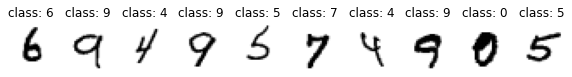

In [ ]:
pltSize = 1
plt.figure(figsize=(10 * pltSize, pltSize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap= "gray_r")
  plt.title('class: ' + str(Y_train[i].item()))

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)
    self.dropout_rate = 0.5
    self.batch_norm1 = nn.BatchNorm1d(512)
    self.batch_norm2 = nn.BatchNorm1d(256)
  def forward(self, x):
    # view vs. reshape
    # view : share value with original data / have advantage in memory usage
    # reshape : new instance / safe in original data
    # x = x.view(-1, 28 * 28)
    x = x.reshape(-1, 28 * 28)
    x = self.fc1(x)
    x = self.batch_norm1(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training, p = self.dropout_rate)
    x = self.fc2(x)
    x = self.batch_norm2(x)
    x = F.relu(x)
    x = F.dropout(x, training = self.training, p = self.dropout_rate)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

In [ ]:
def weight_init(m):
  if isinstance(m, nn.Linear):
    init.kaiming_normal_(m.weight.data)

In [ ]:
model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, epoch, train_loader):
  model.train()

  numOfDataset = 0

  for batch_idx, (X_train, Y_train) in enumerate(train_loader):
    X_train = X_train.to(DEVICE)
    Y_train = Y_train.to(DEVICE)
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()

    numOfDataset += len(X_train)

    if batch_idx % 500 == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\t TrainLoss: {:.6f}".format(
          epoch, numOfDataset, len(train_loader.dataset), 100. * (numOfDataset / len(train_loader.dataset)), loss.item()))

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for X_test, Y_test in test_loader:
      X_test = X_test.to(DEVICE)
      Y_test = Y_test.to(DEVICE)
      output = model(X_test)
      test_loss += criterion(output, Y_test).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(Y_test.view_as(prediction)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_acc = 100. * correct / len(test_loader.dataset)
  return test_loss, test_acc

In [ ]:
for epoch in range(1, EPOCHS + 1):
  train(model, epoch, train_loader)
  test_loss, test_acc = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \t Test Loss: {:.4f}, \t Test Acc: {:.2f} %\n".format(epoch, test_loss, test_acc))


**Test 3**

FashionMNIST
AutoEncoder

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_dataset = datasets.FashionMNIST(root = "/content/drive/MyDrive/MNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "/content/drive/MyDrive/MNIST",
                                      train = False,
                                      download = True,
                                      transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

In [ ]:
for (X_train, Y_train) in train_loader:
  print('X_train:', X_train.size(), 'type: ', X_train.type())
  print('Y_train:', Y_train.size(), 'type: ', Y_train.type())
  break

X_train: torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
Y_train: torch.Size([32]) type:  torch.LongTensor


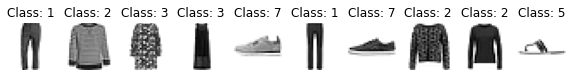

In [ ]:
plt_size = 1
plt.figure(figsize=(10 * plt_size, plt_size))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
  plt.title('Class: ' + str(Y_train[i].item()))

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28 * 28 , 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 32),
    )

    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28*28),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [ ]:
def train(model, train_loader, optimizer):
  model.train()

  numOfDataset = 0
  for batch_idx, (image, _) in enumerate(train_loader):
    image = image.reshape(-1, 28 * 28).to(DEVICE)
    target = image.reshape(-1, 28 * 28).to(DEVICE)
    optimizer.zero_grad()
    encoded, decoded = model(image)
    loss = criterion(decoded, target)
    loss.backward()
    optimizer.step()
    numOfDataset += len(image)
    if batch_idx % 500 == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\t TrainLoss: {:.6f}".format(
          epoch, numOfDataset, len(train_loader.dataset), 100. * (numOfDataset / len(train_loader.dataset)), loss.item()))


In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  real_image = []
  gen_image = []

  with torch.no_grad():
    for image, _ in test_loader:
      image = image.reshape(-1, 28 * 28).to(DEVICE)
      target = image.reshape(-1, 28 * 28).to(DEVICE)
      encoded, decoded = model(image)

      test_loss += criterion(decoded, image).item()
      real_image.append(image.to('cpu'))
      gen_image.append(decoded.to('cpu'))

  test_loss /= len(test_loader.dataset)
  return test_loss, real_image, gen_image

In [ ]:
model = AutoEncoder().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

Train Epoch: 1 [32/60000(0%)]	 TrainLoss: 0.015653
Train Epoch: 1 [16032/60000(27%)]	 TrainLoss: 0.012266
Train Epoch: 1 [32032/60000(53%)]	 TrainLoss: 0.012207
Train Epoch: 1 [48032/60000(80%)]	 TrainLoss: 0.011278

 [EPOCH: 1], 	Test Loss: 0.0004
Train Epoch: 2 [32/60000(0%)]	 TrainLoss: 0.012759
Train Epoch: 2 [16032/60000(27%)]	 TrainLoss: 0.014348
Train Epoch: 2 [32032/60000(53%)]	 TrainLoss: 0.010568
Train Epoch: 2 [48032/60000(80%)]	 TrainLoss: 0.010618

 [EPOCH: 2], 	Test Loss: 0.0004
Train Epoch: 3 [32/60000(0%)]	 TrainLoss: 0.010690
Train Epoch: 3 [16032/60000(27%)]	 TrainLoss: 0.010949
Train Epoch: 3 [32032/60000(53%)]	 TrainLoss: 0.012574
Train Epoch: 3 [48032/60000(80%)]	 TrainLoss: 0.009892

 [EPOCH: 3], 	Test Loss: 0.0003
Train Epoch: 4 [32/60000(0%)]	 TrainLoss: 0.008468
Train Epoch: 4 [16032/60000(27%)]	 TrainLoss: 0.010047
Train Epoch: 4 [32032/60000(53%)]	 TrainLoss: 0.010738
Train Epoch: 4 [48032/60000(80%)]	 TrainLoss: 0.012940

 [EPOCH: 4], 	Test Loss: 0.0003
Trai

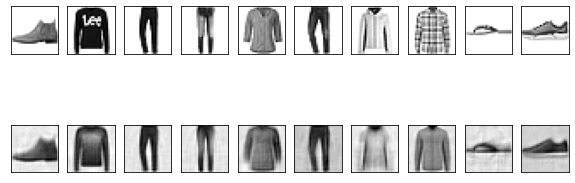

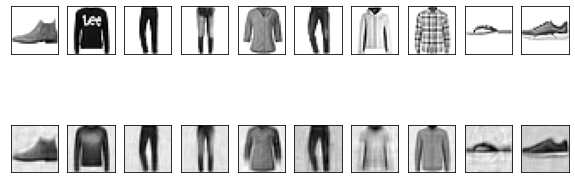

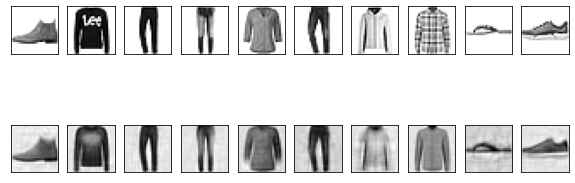

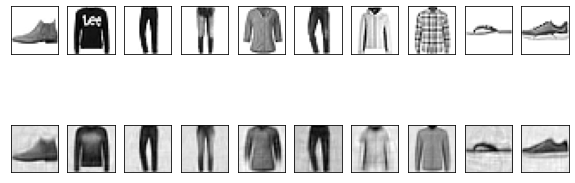

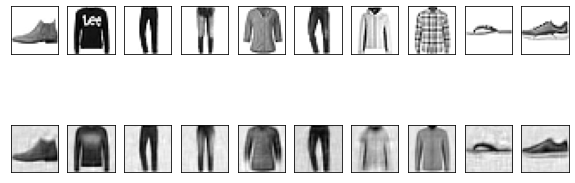

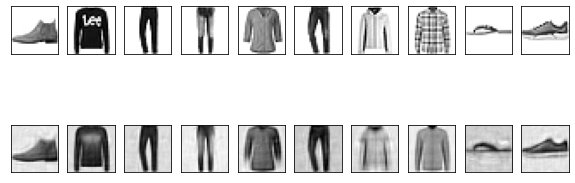

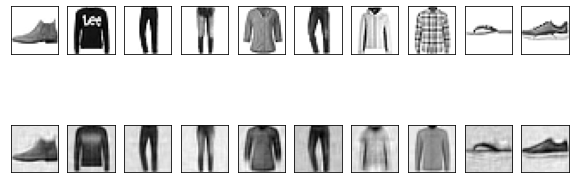

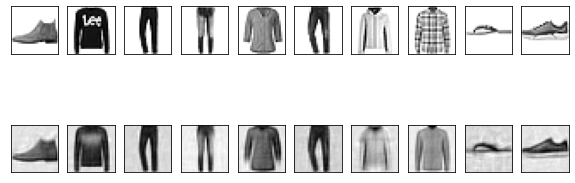

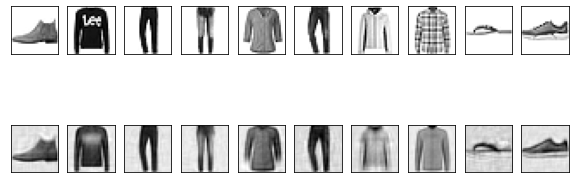

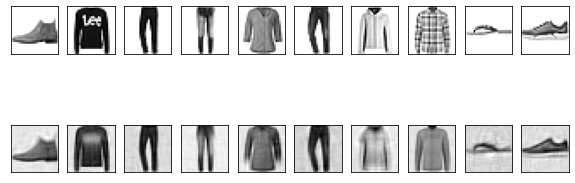

In [ ]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer)
  test_loss, real_image, gen_image = evaluate(model, test_loader)
  print("\n [EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
  f, a = plt.subplots(2, 10, figsize = (10, 4))

  for i in range(10):
    img = np.reshape(real_image[0][i], (28, 28))
    a[0][i].imshow(img, cmap="gray_r")
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
  for i in range(10):
    img = np.reshape(gen_image[0][i], (28, 28))
    a[1][i].imshow(img, cmap="gray_r")
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())

**Test 4 CIFAR-10**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = troch.device('cpu')

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

In [ ]:
train_dataset = datasets.CIFAR10("/content/drive/MyDrive/MNIST", True, 
                      transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,]), None, True)
test_dataset = datasets.CIFAR10("/content/drive/MyDrive/MNIST", False, 
            transforms.Compose([transforms.ToTensor(),
            normalize]), None, True)
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, True)
test_loader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
for (X_train, Y_train) in train_loader:
  print("X_train: ", X_train.size(), "type: " , X_train.type())
  print("Y_train: ", Y_train.size(), "type: " , Y_train.type())
  break

X_train:  torch.Size([32, 3, 32, 32]) type:  torch.FloatTensor
Y_train:  torch.Size([32]) type:  torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

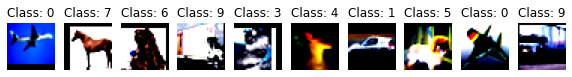

In [ ]:
plt_size = 1
plt.figure(figsize=(10*plt_size, plt_size))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1,2,0)))
  plt.title("Class: " + str(Y_train[i].item()))

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.conv1 = nn.Conv2d(3, 32, (5,5), (1,1), 2)
    self.pool = nn.MaxPool2d((2,2), (2,2))
    self.fc1 = nn.Linear(16 * 16 * 32, 1024)
    self.output = nn.Linear(1024, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = x.reshape(-1, 16*16*32)
    x = F.relu(self.fc1(x))
    x = F.log_softmax(self.output(x))
    return x

In [ ]:
model = Model().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
def train(model, train_loader, optimizer):
  model.train()
  numOfDataset = 0
  for batch_idx, (X_train, Y_train) in enumerate(train_loader):
    X_train = X_train.to(DEVICE)
    Y_train = Y_train.to(DEVICE)
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    numOfDataset += len(X_train)
    if batch_idx % 500 == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\t TrainLoss: {:.6f}".format(
          epoch, numOfDataset, len(train_loader.dataset), 100. * (numOfDataset / len(train_loader.dataset)), loss.item()))

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for (X_test, Y_test) in test_loader:
      X_test = X_test.to(DEVICE)
      Y_test = Y_test.to(DEVICE)
      output = model(X_test)
      test_loss += criterion(output, Y_test).item()
      _, prediction = torch.max(output, 1)
      correct += (Y_test == prediction).sum().item()

  test_loss /= len(test_loader.dataset)
  test_acc = 100 * correct / len(test_loader.dataset)
  return test_loss, test_acc

In [ ]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer)
  test_loss, test_Acc = evaluate(model, test_loader)
  print("\n [EPOCH: {}], \tTest Loss: {:.4f} \tTest Acc {:.4f}".format(epoch, test_loss, test_Acc))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Train Epoch: 1 [32/50000(0%)]	 TrainLoss: 2.321775
Train Epoch: 1 [16032/50000(32%)]	 TrainLoss: 1.506176
Train Epoch: 1 [32032/50000(64%)]	 TrainLoss: 1.707561
Train Epoch: 1 [48032/50000(96%)]	 TrainLoss: 1.308555

 [EPOCH: 1], 	Test Loss: 0.0416 	Test Acc 52.8200
Train Epoch: 2 [32/50000(0%)]	 TrainLoss: 1.395461
Train Epoch: 2 [16032/50000(32%)]	 TrainLoss: 1.222435
Train Epoch: 2 [32032/50000(64%)]	 TrainLoss: 1.492527
Train Epoch: 2 [48032/50000(96%)]	 TrainLoss: 1.542942

 [EPOCH: 2], 	Test Loss: 0.0361 	Test Acc 59.0500
Train Epoch: 3 [32/50000(0%)]	 TrainLoss: 1.431594
Train Epoch: 3 [16032/50000(32%)]	 TrainLoss: 1.275123
Train Epoch: 3 [32032/50000(64%)]	 TrainLoss: 1.163423
Train Epoch: 3 [48032/50000(96%)]	 TrainLoss: 1.606176

 [EPOCH: 3], 	Test Loss: 0.0335 	Test Acc 62.6200
Train Epoch: 4 [32/50000(0%)]	 TrainLoss: 1.355975
Train Epoch: 4 [16032/50000(32%)]	 TrainLoss: 1.300223
Train Epoch: 4 [32032/50000(64%)]	 TrainLoss: 1.013616
Train Epoch: 4 [48032/50000(96%)]	 Tra

In [ ]:
len(train_loader.dataset)

50000

**TEST 5 RESNET**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = troch.device('cpu')

In [ ]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
BATCH_SIZE = 32
EPOCHS = 10

In [ ]:
train_dataset = datasets.CIFAR10("/content/drive/MyDrive/MNIST", True, 
                      transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,]), None, True)
test_dataset = datasets.CIFAR10("/content/drive/MyDrive/MNIST", False, 
            transforms.Compose([transforms.ToTensor(),
            normalize]), None, True)
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, True)
test_loader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class ZeroPadding(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super(ZeroPadding, self).__init__()
    self.pooling = nn.MaxPool2d(1, stride=stride)
    self.add_channels = out_channels - in_channels
  
  def forward(self, x):
    out = F.pad(x, (0, 0, 0, 0, 0, self.add_channels))
    out = self.pooling(out)
    return out

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride, version = "CIFAR"):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU(True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU(True)
    self.version = version
    self.shortcut = nn.Sequential()
    if in_channels != out_channels or stride != 1:
      if version == "CIFAR":
        self.shortcut = ZeroPadding(in_channels, out_channels, stride)
      else:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride),
            nn.BatchNorm2d(out_channels)
        )

  def forward(self, x):
    tx = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x += self.shortcut(tx)
    x = self.relu2(x)
    return x

In [ ]:
class ResNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(ResNet, self).__init__()

    self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU(True)
    self.layer1 = self.make_layer(16, 16, 2, 1)
    self.layer2 = self.make_layer(16, 32, 2, 2)
    self.layer3 = self.make_layer(32, 64, 2, 2)
    self.pool = nn.AvgPool2d(8, stride = 1)
    self.linear = nn.Linear(64, num_classes)
    
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
  
  def make_layer(self, in_channels, out_channels, num_blocks, stride):
    layers = []
    layers.append(
        ResidualBlock(in_channels, out_channels, stride)
    )

    for _ in range(num_blocks - 1):
      layers.append(ResidualBlock(out_channels, out_channels, 1))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.pool(x)
    x = x.reshape(x.size(0), -1)
    x = self.linear(x)
    return x


In [ ]:
model = ResNet().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 0.1, 0.9, weight_decay=1e-4)

In [ ]:
def train(model, train_loader, optimizer):
  model.train()
  numOfDataset = 0
  for batch_idx, (X_train, Y_train) in enumerate(train_loader):
    X_train = X_train.to(DEVICE)
    Y_train = Y_train.to(DEVICE)
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    numOfDataset += len(X_train)
    if batch_idx % 500 == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\t TrainLoss: {:.6f}".format(
          epoch, numOfDataset, len(train_loader.dataset), 100. * (numOfDataset / len(train_loader.dataset)), loss.item()))

In [ ]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for (X_test, Y_test) in test_loader:
      X_test = X_test.to(DEVICE)
      Y_test = Y_test.to(DEVICE)
      output = model(X_test)
      test_loss += criterion(output, Y_test).item()
      _, prediction = torch.max(output, 1)
      correct += (Y_test == prediction).sum().item()

  test_loss /= len(test_loader.dataset)
  test_acc = 100 * correct / len(test_loader.dataset)
  return test_loss, test_acc

In [ ]:
for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer)
  test_loss, test_Acc = evaluate(model, test_loader)
  print("\n [EPOCH: {}], \tTest Loss: {:.4f} \tTest Acc {:.4f}".format(epoch, test_loss, test_Acc))


Train Epoch: 1 [32/50000(0%)]	 TrainLoss: 2.618979
Train Epoch: 1 [16032/50000(32%)]	 TrainLoss: 1.667944
Train Epoch: 1 [32032/50000(64%)]	 TrainLoss: 1.335773
Train Epoch: 1 [48032/50000(96%)]	 TrainLoss: 1.260865

 [EPOCH: 1], 	Test Loss: 0.0504 	Test Acc 47.5100
Train Epoch: 2 [32/50000(0%)]	 TrainLoss: 1.333258
Train Epoch: 2 [16032/50000(32%)]	 TrainLoss: 1.221501
Train Epoch: 2 [32032/50000(64%)]	 TrainLoss: 1.043569
Train Epoch: 2 [48032/50000(96%)]	 TrainLoss: 1.133817

 [EPOCH: 2], 	Test Loss: 0.0355 	Test Acc 62.1500
Train Epoch: 3 [32/50000(0%)]	 TrainLoss: 1.189614
Train Epoch: 3 [16032/50000(32%)]	 TrainLoss: 0.856325
Train Epoch: 3 [32032/50000(64%)]	 TrainLoss: 1.068272
Train Epoch: 3 [48032/50000(96%)]	 TrainLoss: 1.380332

 [EPOCH: 3], 	Test Loss: 0.0338 	Test Acc 65.8000
Train Epoch: 4 [32/50000(0%)]	 TrainLoss: 0.525132
Train Epoch: 4 [16032/50000(32%)]	 TrainLoss: 0.588800
Train Epoch: 4 [32032/50000(64%)]	 TrainLoss: 0.608241
Train Epoch: 4 [48032/50000(96%)]	 Tra

**Test 6 Pretrained Model**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchvision.models as models

model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
BATCH_SIZE = 32
EPOCHS = 10

train_dataset = datasets.CIFAR10("/content/drive/MyDrive/MNIST", True, 
                      transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,]), None, True)
test_dataset = datasets.CIFAR10("/content/drive/MyDrive/MNIST", False, 
            transforms.Compose([transforms.ToTensor(),
            normalize]), None, True)
train_loader = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, True)
test_loader = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 0.001)

def train(model, train_loader, optimizer):
  model.train()
  numOfDataset = 0
  for batch_idx, (X_train, Y_train) in enumerate(train_loader):
    X_train = X_train.to(DEVICE)
    Y_train = Y_train.to(DEVICE)
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    numOfDataset += len(X_train)
    if batch_idx % 500 == 0:
      print("Train Epoch: {} [{}/{}({:.0f}%)]\t TrainLoss: {:.6f}".format(
          epoch, numOfDataset, len(train_loader.dataset), 100. * (numOfDataset / len(train_loader.dataset)), loss.item()))

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for (X_test, Y_test) in test_loader:
      X_test = X_test.to(DEVICE)
      Y_test = Y_test.to(DEVICE)
      output = model(X_test)
      test_loss += criterion(output, Y_test).item()
      _, prediction = torch.max(output, 1)
      correct += (Y_test == prediction).sum().item()

  test_loss /= len(test_loader.dataset)
  test_acc = 100 * correct / len(test_loader.dataset)
  return test_loss, test_acc

for epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer)
  test_loss, test_Acc = evaluate(model, test_loader)
  print("\n [EPOCH: {}], \tTest Loss: {:.4f} \tTest Acc {:.4f}".format(epoch, test_loss, test_Acc))


Train Epoch: 1 [32/50000(0%)]	 TrainLoss: 2.718580
Train Epoch: 1 [16032/50000(32%)]	 TrainLoss: 1.327052
Train Epoch: 1 [32032/50000(64%)]	 TrainLoss: 1.222350
Train Epoch: 1 [48032/50000(96%)]	 TrainLoss: 1.301128

 [EPOCH: 1], 	Test Loss: 0.0302 	Test Acc 68.1300
Train Epoch: 2 [32/50000(0%)]	 TrainLoss: 0.965396
Train Epoch: 2 [16032/50000(32%)]	 TrainLoss: 0.994935
Train Epoch: 2 [32032/50000(64%)]	 TrainLoss: 0.650928
Train Epoch: 2 [48032/50000(96%)]	 TrainLoss: 1.078826

 [EPOCH: 2], 	Test Loss: 0.0310 	Test Acc 69.5600
Train Epoch: 3 [32/50000(0%)]	 TrainLoss: 0.663777
Train Epoch: 3 [16032/50000(32%)]	 TrainLoss: 0.790451
Train Epoch: 3 [32032/50000(64%)]	 TrainLoss: 1.005887
Train Epoch: 3 [48032/50000(96%)]	 TrainLoss: 1.019586

 [EPOCH: 3], 	Test Loss: 0.0234 	Test Acc 74.9400
Train Epoch: 4 [32/50000(0%)]	 TrainLoss: 0.779978
Train Epoch: 4 [16032/50000(32%)]	 TrainLoss: 0.773557
Train Epoch: 4 [32032/50000(64%)]	 TrainLoss: 1.309918
Train Epoch: 4 [48032/50000(96%)]	 Tra